# Classification binary

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from astropy.io import fits 
# Import interaction module
from ipywidgets.widgets import *
import itertools
import random
import galsim
import copy

import sys
import os
import math
import subprocess as sp
# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler,scale
from sklearn.preprocessing import normalize,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

if not os.path.isdir('files'):
        os.mkdir('files') # To manage the images created
        
# Load the galaxy data from a binary file.
galaxy = np.load('galaxy_cube_10000.npy')
train = galaxy[:9000]
test = galaxy[9000:10000]

We measure the size of galaxies in x and y,  these sizes will be used to define the distance of blended and non-blended sources.

In [2]:
# A fonction to give the size for every object
def siz(data):
    size = []
    for i in range(data.shape[0]):
        x = np.array(np.where(np.sum(data[i], axis = 0) != 0)).shape[1]
        y = np.array(np.where(np.sum(data[i], axis = 1) != 0)).shape[1]
        s = [x,y]
        size.append(s)
    return np.array(size)

galaxy_size = siz(galaxy)

blend_size = galaxy_size[:4500]
noblend_size = galaxy_size[4500:9000]

blend_size_test = galaxy_size[9000:9500]
noblend_size_test = galaxy_size[9500:10000]



##  Create blended and non-blended objects in the same size images

In [3]:
# Define a function of creating the fake image by two different great3 galaxies
def create_image(gal, fov, flag, filename, siz=[5,5], noise=True, save=False, plot=True):
    
    center = np.zeros([gal.shape[0]/2, siz[0]*gal[0].shape[0], siz[0]*gal[0].shape[1]])
    flags = np.zeros([gal.shape[0]/2])

    # Choose two different Sersic galaxies
    ser_center = gal[:gal.shape[0]/2]
    ser_around = gal[gal.shape[0]/2:gal.shape[0]]
    
    # Random position of second source
    x_around = fov[:fov.shape[0], 0]
    y_around = fov[:fov.shape[0], 1]
   
    # cenpos = [41, 41]
    cenpos = [siz[0]*gal[0].shape[0]/2+1,siz[0]*gal[0].shape[0]/2+1]
  
    
    for i in range(gal.shape[0]/2):
    
    # Combine the objects
        im = np.zeros([2,ser_center[0].shape[0], ser_center[0].shape[1]])
        
        im[0] = np.array(gal[i])
        im[1] = np.array(gal[i+gal.shape[0]/2])
    
        image = np.zeros([siz[0]*gal[i].shape[0], siz[1]*gal[i].shape[1]])
        
        image[cenpos[0]-(im[0].shape[0]-1)/2 : cenpos[0]+(im[0].shape[0]-1)/2+1, 
              cenpos[1]-(im[0].shape[0]-1)/2 : cenpos[1]+(im[0].shape[0]-1)/2+1] = im[0]
        
        image[x_around[i]-(im[1].shape[0]-1)/2-1 : x_around[i]+(im[1].shape[0]-1)/2, 
              y_around[i]-(im[1].shape[0]-1)/2-1 : y_around[i]+(im[1].shape[0]-1)/2] += im[1]        
        
        center[i] = image[cenpos[0]-siz[0]*(im[0].shape[0]-1)/2-3 : cenpos[0]+siz[0]*(im[0].shape[0]-1)/2+3, 
                          cenpos[1]-siz[0]*(im[0].shape[0]-1)/2-3: cenpos[1]+siz[0]*(im[0].shape[0]-1)/2+3]
        
 
        # Add noise on every picture   
        if noise:
            center[i] += np.random.normal(scale=5e-3, size=[siz[0]*gal[0].shape[0], siz[1]*gal[0].shape[1]])
    
        flags[i] = np.array(flag) 
        
        
        
    # Save array to a FITS file                    
        if save:
            fits.PrimaryHDU(center[i]).writeto('files/'+filename+str(i)+'.fits', overwrite=True)#, clobb6r=True) 
    
    
    # Print some vignets of the object 
    if plot:
 
        for j in np.random.choice(range(center.shape[0]),1):#range(center.shape[0]): # 
            plt.figure(figsize = (12, 8))
            plt.imshow(center[j], interpolation='Nearest', cmap='viridis')
            plt.colorbar()
            plt.title('No.'+str(j+1)+'  '+'Flag of the object:'+str(flag))#+str(flags[j]), fontsize=12)
            plt.show()
    
    return center, flags.astype(int)



In [4]:
# The x,y side boundary distance between two souces
dis = blend_size[:2250] + blend_size[2250:4500]
dis_non = noblend_size[:2250] + noblend_size[2250:4500]

# Generate the random position for the second source 
'''These positions are repetitive sometimes'''
def blend_position(n, sigmax, sigmay, distance): 
    p = np.zeros([n,2])
    np.random.seed(16)
    for i in range(n): 
        p[i, 0] = np.random.randint(103 - sigmax*distance[i,0], 103 + sigmax*distance[i,0])
        p[i, 1] = np.random.randint(103 - sigmay*distance[i,1], 103 + sigmay*distance[i,1])

    return p.astype(int)


def noblend_position(n, sigmax, sigmay, distance, low = 41, high = 165): #21, 186 
    p = np.zeros([n,2])
    np.random.seed(18)
    for i in range(n): 
        x0 = np.random.randint(low, 103 - sigmax*distance[i,0])   
        x1 = np.random.randint(103 + sigmax*distance[i,0], high)
        x = [x0,x1]
        p[i, 0] = np.random.choice(x,1)
        
        y0 = np.random.randint(low, 103 - sigmay*distance[i,1])
        y1 = np.random.randint(103 + sigmay*distance[i,1], high)
        y = [y0,y1]
        p[i, 1] = np.random.choice(y,1)
        
    return p.astype(int)

pos_blend = blend_position(2250, sigmax = 0.15, sigmay = 0.15, distance = dis)

pos_noblend = noblend_position(2250, sigmax = 1, sigmay = 1, distance = dis_non) #21,186

# Check the number in the appointed range

#print np.where((pos_noblend[:,0]>98) & (pos_noblend[:,0]<108))


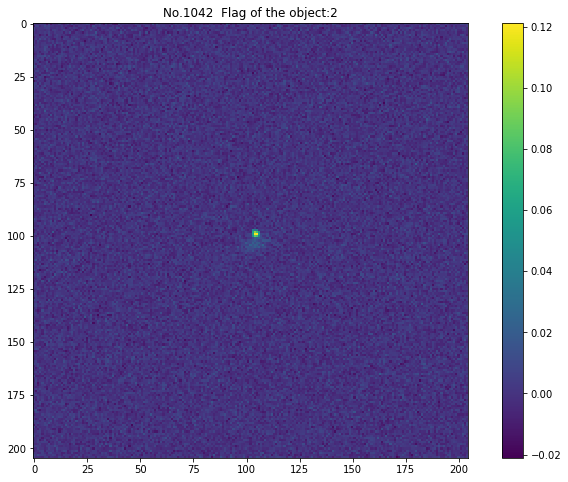

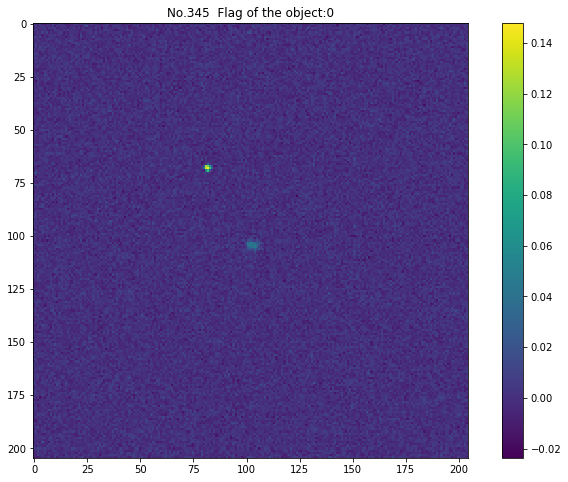

In [5]:
# Create blended and non-blended data
blend, flags_blend= create_image(train[:4500], pos_blend, 2, filename='blend',
                                 siz=[5,5], save=False, plot=True)

noblend, flags_noblend = create_image(train[4500:9000], pos_noblend, 0,filename='noblend',
                                      siz=[5,5], save=False, plot=True)


Here, we need mix the order of blended and non-blended sources together.

In [6]:
# This is a function to mix the blended and non-blended sources
def mix(ble, fla_ble, noble, fla_noble):
    
    data_blend = {'vignet': [ble[i] for i in range(ble.shape[0])],
            'flag': [fla_ble[i] for i in range(fla_ble.shape[0])]}
    data_noblend = {'vignet': [noble[i] for i in range(noble.shape[0])],
            'flag': [fla_noble[i] for i in range(fla_noble.shape[0])]}

    data_blend = DataFrame(data_blend)
    data_noblend = DataFrame(data_noblend)
    result = pd.concat([data_blend, data_noblend], axis=0, ignore_index=True)

    np.random.seed(1000)

    result = result.sample(frac=1).reset_index(drop=True)

    
    return result

datatrain = mix(blend, flags_blend, noblend, flags_noblend)

objs_train = np.array([datatrain['vignet']], dtype=float)[0]
flag_train = np.array([datatrain['flag']], dtype=float)[0]



And then, we create the test images.

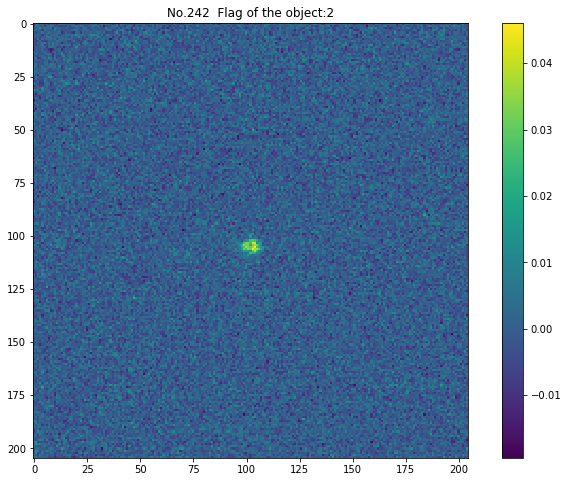

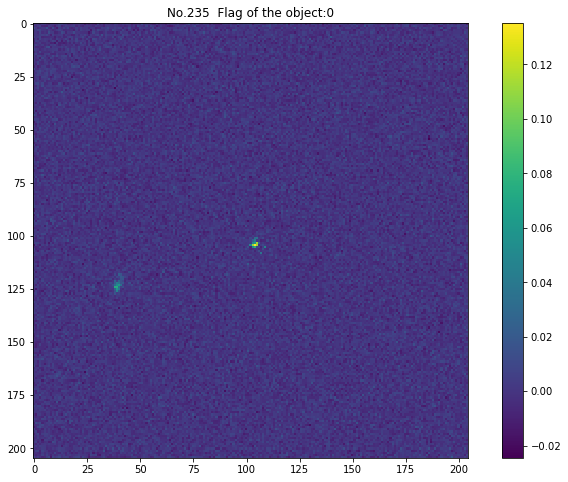

In [7]:
# The boundary distance between two souces
dis_test = blend_size_test[:250] + blend_size[250:500]
dis_non_test = noblend_size_test[:250] + noblend_size[250:500]

# Define the position for test objects
pos_blend_test = blend_position(250, sigmax = 0.15, sigmay = 0.15, distance = dis_test)

pos_noblend_test = noblend_position(250, sigmax = 1, sigmay = 1, distance = dis_non_test, low = 41, high = 165) #21,186

# Create the test images

blend_test, flags_blend_test= create_image(test[:500], pos_blend_test, 2, 'blend_test',
                                           siz=[5,5], save=True, plot=True)

noblend_test, flags_noblend_test= create_image(test[500:1000], pos_noblend_test, 0, 'noblend_test',
                                           siz=[5,5], save=True, plot=True)

In [8]:
# Mix blend and non-blend test data together
datatest = mix(blend_test, flags_blend_test, noblend_test, flags_noblend_test)
objs_test= np.array([datatest['vignet']], dtype=float)[0]
flag_test = np.array([datatest['flag']], dtype=int)[0]


## Neural network for training and testing
Until now, we get all the data of training and testing for my neural network, therefor, we are able to compare the sex's and nn's results.

In [9]:
def ploteva(sex, ann, n_class, label_1, label_2, title):
     
    #fig, ax = plt.subplot(1,2,sub)
   
    index = np.arange(n_class)  
    bar_width = 0.1  
    opacity = 0.8
    plt.bar(index, sex, bar_width, alpha=opacity, color='b', label=label_1)  
    plt.bar(index + bar_width, ann, bar_width, alpha=opacity, color='r', label=label_2)  
    plt.xlabel('Class')  
    plt.ylabel('Numbers')
    plt.legend()
    plt.title(title)  
    plt.xticks(index)# + bar_width/2)#, ('0', '1'))  
    
def classify(attributes, targets, attri_test, targ_test, clf):
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(attributes)
    #X_train = normalize(attributes)
    y_train = targets

    X_test = scaler.transform(attri_test)
    #X_test = normalize(attri_test)
    y_test = targ_test

    # Fit and training data
    clf.fit(X_train, y_train)
    
    
    # Predict the training
    y_train_pred = clf.predict(X_train)
    
    # Predict the testing
    y_true = y_test
    y_pred = clf.predict(X_test)
      
    # Evaluation of the training
    Y_SEX = [np.shape(np.where(y_train <= 1))[1],np.shape(np.where(y_train >= 2))[1]]
    Y_ANN = [np.shape(np.where(y_train_pred <= 1))[1],np.shape(np.where(y_train_pred >= 2))[1]]
    
    # Evaluation of the testing
    Y_SEX_test = [np.shape(np.where(y_true <= 1))[1],np.shape(np.where(y_true >= 2))[1]]
    Y_ANN_test = [np.shape(np.where(y_pred <= 1))[1],np.shape(np.where(y_pred >= 2))[1]]
    
    # Plot the evaluation
    plt.figure(figsize=(10, 3))
    plt.subplot(121)
    ploteva(Y_SEX,Y_ANN,2,'Original','ANN','Evaluation_training')
    plt.subplot(122)
    ploteva(Y_SEX_test,Y_ANN_test,2,'Original','ANN','Evaluation_testing')
    plt.show()
    print (confusion_matrix(y_train, y_train_pred))

    print (confusion_matrix(y_true, y_pred))
    print (classification_report(y_true, y_pred))
    return y_pred


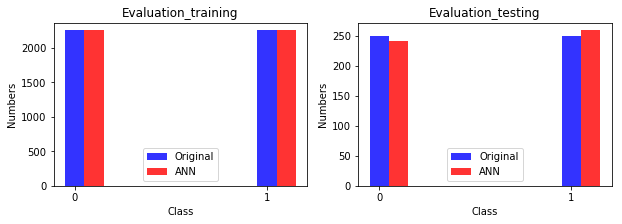

[[2250    0]
 [   0 2250]]
[[212  38]
 [ 29 221]]
             precision    recall  f1-score   support

          0       0.88      0.85      0.86       250
          2       0.85      0.88      0.87       250

avg / total       0.87      0.87      0.87       500



In [10]:
# Divide data frame into features and labels
labels = flag_train
feat = objs_train
features = feat.reshape(feat.shape[0], feat.shape[1]**2)

labels_test = flag_test
feat_test = objs_test
features_test = feat_test.reshape(feat_test.shape[0],feat_test.shape[1]**2)

# Choose the model of classification
#mod = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500, alpha=1e-4,solver='sgd', learning_rate_init=.001)
mod = MLPClassifier(hidden_layer_sizes=(30,30,30), solver='lbfgs', alpha=1e-5, max_iter=500,random_state=100)
#mod = KNeighborsClassifier(n_neighbors=5)
#mod = SVC(gamma=0.001, C=100., kernel='rbf')

y_pred = classify(features, labels, features_test, labels_test, mod)



## Result for SExtractor
To run the SExtractor on every object, we need save every object as a fits file.

In [11]:
# Generate the index for true blended and non-blended objects among the mix testing images
a = []
for i in range(objs_test.shape[0]):
    if flag_test[i] == 0:
        a.append(i)
        aa = np.array(a)
        
b = []
for i in range(objs_test.shape[0]):
    if flag_test[i] == 2:
        b.append(i)
        bb = np.array(b)
        
        
# A function to change the flag as two dimention
def change_flag(test):
    nn = np.zeros([test.shape[0],1,2])
    for j in range(test.shape[0]):
        if test[j] == 0:
            nn[j] = [0,0]
        if test[j] == 2:
            nn[j] = [2,2]
    return nn.astype(int)

flagtest = change_flag(flag_test)
flagnn = change_flag(y_pred)



In [12]:
def sexparam(detecte_min, detect_thr, deblend_nth, deblend_min, objs , fitsname = 'datatest', catname = 'nonoise.cat'):
    # initialize variables
    one= []
    one_blend = []
    oneblend_0 = []
    oneblend_2 = []
    one_noblend = []
    onenoblend_0 = []
    onenoblend_2 = []
    flag1_noblend = []
    flag1_blend = []

    two = []
    two_blend = []
    two_noblend = []
    two_noandblend = []
    two_blendandno = []
    flag2_noblend = []
    flag2_blend = []

    noexcep = []
    flagsex = []
    snr_sex = []
    
    blend_twoobj = []
    noblend_twoobj = []    
     

    # Run SExtractor on every object and compare the result with true flags and network flags
    
    for i in range(objs.shape[0]):

        fits.PrimaryHDU(np.array(objs[i], dtype=float)).writeto('files/'+fitsname+str(i)+'.fits', overwrite=True)#, clobb6r=True)
        command = 'sex '+'files/'+fitsname+str(i)+'.fits -CATALOG_NAME '+'files/'+catname+' -DETECT_MINAREA {} -ANALYSIS_THRESH {} -DETECT_THRESH {} -DEBLEND_NTHRESH {} -DEBLEND_MINCONT {}'
        output = sp.Popen([command.format(detecte_min, detect_thr, detect_thr, deblend_nth, deblend_min)] , stdout=sp.PIPE, stderr=sp.PIPE, shell=True).stderr.read()

        # open SExtractor catalog:
        cat = fits.open('files/'+catname)
        # get the data from the second object of the fits file we opened
        data = cat[2].data
        flag_sex = np.array([obj['FLAGS'] for obj in data])
        sex = [obj['FLAGS'] for obj in data]
        
        snr = [obj['SNR_WIN'] for obj in data]
        # Generate the sextractor's flag result
        flagsex.append(sex)
        snr_sex.append(snr)
        
        if flag_sex.size == 1:
            one.append(i)

            if i in bb:
                one_blend.append(i)

                if flag_sex == [0]:
                    oneblend_0.append(i)

                else:
                    oneblend_2.append(i)

            if i in aa:
                one_noblend.append(i)

                if flag_sex == [0]:
                    onenoblend_0.append(i)

                else:
                    onenoblend_2.append(i)


        # Extract the network flags    
            if (flagnn[i] == [0, 0]).all():
                flag1_noblend.append(i)      
            else:
                flag1_blend.append(i)


        if flag_sex.size == 2:
            two.append(i)

            if (flag_sex == [2, 2]).all():
                two_blend.append(i)

            if (flag_sex == [0, 0]).all():
                two_noblend.append(i)

            if (flag_sex == [0, 2]).all():
                two_noandblend.append(i)

            if (flag_sex == [2, 0]).all():      
                two_blendandno.append(i)

        # Extract the network flags         
            if (flagnn[i] == [0, 0]).all():
                flag2_noblend.append(i)  
            else:
                flag2_blend.append(i)


        if flag_sex.size > 2:
                noexcep.append(i)

    # the total flags of SExtractor            
    flagofsex       = np.array(flagsex)
    snrsex          = np.array(snr_sex)
    
    # Where sextractor detects only one object
    oneobj          = np.array(one)
    oneblend        = np.array(one_blend)
    oneblend0       = np.array(oneblend_0)
    oneblend2       = np.array(oneblend_2)
    onenoblend0     = np.array(onenoblend_0)
    onenoblend2     = np.array(onenoblend_2)  
    onenoblend      = np.array(one_noblend)
    flag1noblend    = np.array(flag1_noblend)
    flag1blend      = np.array(flag1_blend)

    # Where sextractor detects two objects
    twoobj          = np.array(two)
    twoblend        = np.array(two_blend)
    twonoblend      = np.array(two_noblend)                        
    twonoandblend   = np.array(two_noandblend)
    twoblendandno   = np.array(two_blendandno)
    flag2noblend    = np.array(flag2_noblend)
    flag2blend      = np.array(flag2_blend)

    # Where sextractor detects more than two objects
    noexc           = np.array(noexcep)
    
    
    # Delete the onenoblend sources from the result of neural network

    flagblenda = np.array([item for item in flag1_noblend if item not in one_noblend])
    flagblendb = np.array([item for item in flag1_blend if item not in one_noblend])
    
    # Calcule the amount of true blended and non-blended flags respectively  
    true_non_blend = []
    true_blend = []
    for i in twoobj:
        if flag_test[i]==0:
            true_non_blend.append(i)   
        else:
            true_blend.append(i)

    true_nonblend = np.array(true_non_blend)
    trueblend = np.array(true_blend)

    # Compare with tree different method
    true = ([true_nonblend.shape[0], 
             trueblend.shape[0] + oneblend.shape[0]])  # flag_test
    sex  = ([oneblend0.shape[0] + twonoblend.shape[0],
             oneblend2.shape[0] + twoblend.shape[0] + twonoandblend.shape[0]+twoblendandno.shape[0]])   # flag_sex
    nn   = ([flagblenda.shape[0] + flag2noblend.shape[0], 
             flagblendb.shape[0] + flag2blend.shape[0]]) # flagnn

    return true,sex,nn,flagofsex,oneblend0,oneblend2,onenoblend,twoobj,twoblend,twonoblend,twonoandblend,twoblendandno,noexc,snrsex


## Analyse the most propre detective parameters
We know that every image has two objects，but there exist a problem of detection by sextractor.

In [13]:
# Define the range of detection paramaters
det_min = np.arange(5,55,5)
# Here, we should notice that the range is different with noiseless image due to the 'THRESH_TYPE' in configuration file now is 'RELATIVE'
det_thr = np.linspace(1+1e-2,1+5e-1,15)  
print det_min.shape[0]
print det_thr


10
[ 1.01   1.045  1.08   1.115  1.15   1.185  1.22   1.255  1.29   1.325
  1.36   1.395  1.43   1.465  1.5  ]


In [34]:
N_twonoblend = []

for j in range(det_thr.shape[0]):
    for i in range(det_min.shape[0]):
        flagtrue,flagsextractor,flagnetwork,flagofsex,oneblend0,oneblend2,onenoblend,twoobj,twoblend,twonoblend,twonoandblend,twoblendandno,more2,snr = sexparam(det_min[i], det_thr[j], 
                                                                            deblend_nth=64, deblend_min=1, objs = noblend_test,fitsname = 'nobletest', catname = 'nonoisenoble.cat')
        
        N_twonoblend.append(twonoblend.shape[0])
      

In [35]:
np.save("detect_N_twonoblend.npy",N_twonoblend)


In [14]:
N_twonoblend = np.load('detect_N_twonoblend.npy')
N_two = np.array(N_twonoblend).reshape(det_thr.shape[0],det_min.shape[0])


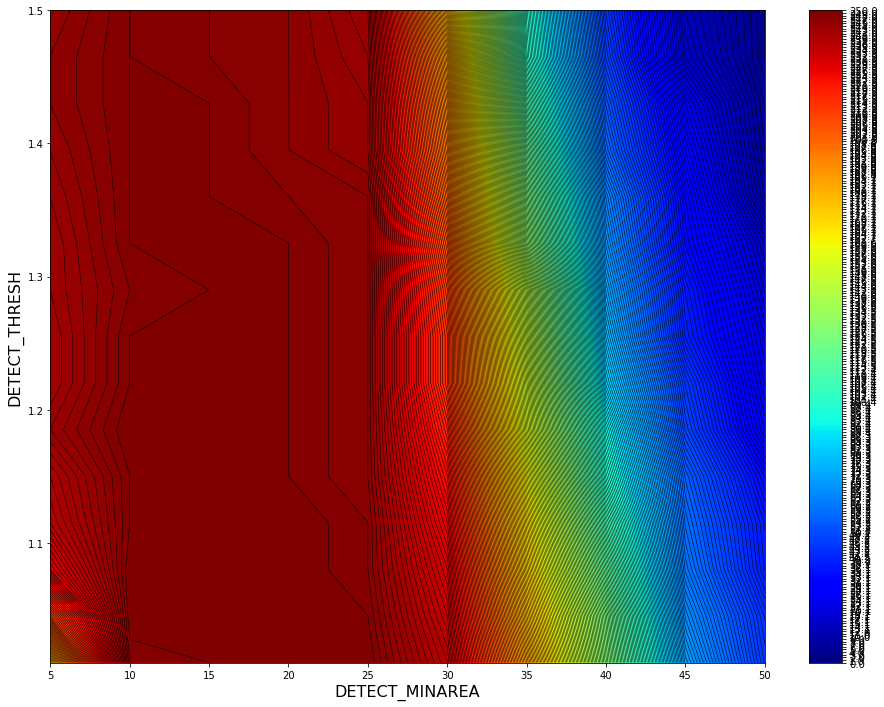

In [15]:
v = np.linspace(0., 250.0, 250, endpoint=True)
plt.figure(figsize = (16,12))
plt.contour(det_min, det_thr, N_two, v, linewidths=0.5, colors='k')
plt.contourf(det_min, det_thr, N_two, v, cmap=plt.cm.jet)
plt.xlabel('DETECT_MINAREA',fontsize=16)
plt.ylabel('DETECT_THRESH',fontsize=16)
x = plt.colorbar(ticks=v)
print x

plt.show()



In [16]:
# print np.array(np.where(np.array(N_twonoblend)==np.max(N_twonoblend))).shape[1]
# print np.where(N_two==np.max(N_two))[0]
# print np.where(N_two==np.max(N_two))[1]
# print np.max(N_two)
# print det_min[6]
# print det_thr[1]

# det_thr_sel= np.where(N_two==np.max(N_two))[0]
# det_min_sel= np.where(N_two==np.max(N_two))[1]

# print np.where(det_min_sel==1)


In [40]:

N_more22 = []
for j in range(det_thr.shape[0]):
    for i in range(det_min.shape[0]):
        flagtrue2,flagsextractor2,flagnetwork2,flagofsex2,oneblend02,oneblend22,onenoblend2,twoobj2,twoblend2,twonoblend2,twonoandblend2,twoblendandno2,more22,snr2 = sexparam(det_min[i], det_thr[j], 
                                                                            deblend_nth=64, deblend_min=1, objs = objs_test,fitsname = 'more2', catname = 'more2.cat')
        
        N_more22.append(more22.shape[0])



In [41]:
np.save("detect_N_more22.npy",N_more22)


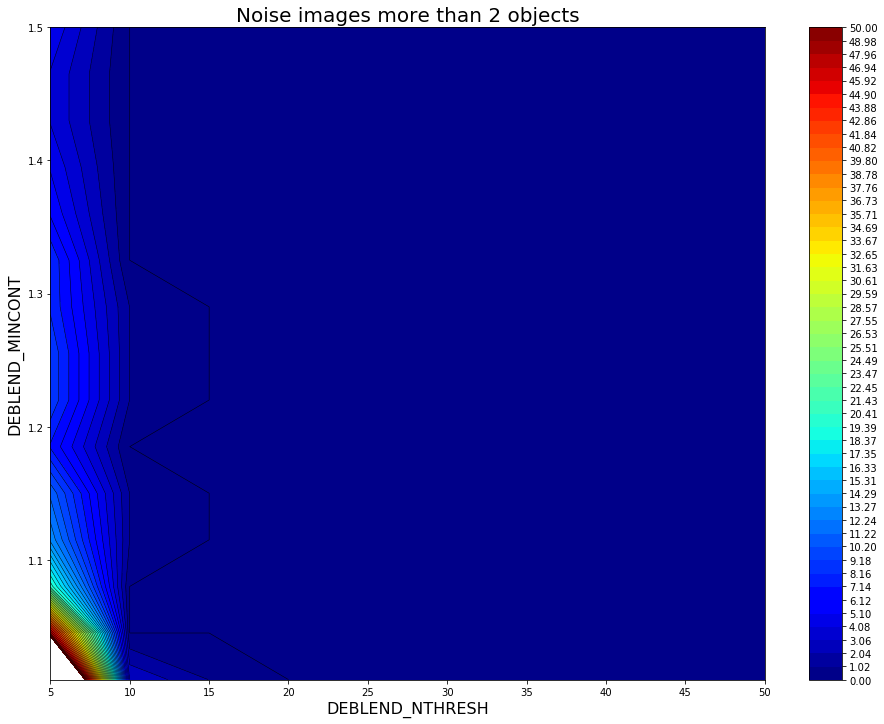

In [60]:

N_more22 = np.load("detect_N_more22.npy")
N_moretwo = np.array(N_more22).reshape(det_thr.shape[0],det_min.shape[0])
v = np.linspace(0., 50.0, 50, endpoint=True)
plt.figure(figsize = (16,12))
plt.contour(det_min, det_thr, N_moretwo, v, linewidths=0.5, colors='k')
plt.contourf(det_min, det_thr, N_moretwo, v, cmap=plt.cm.jet)
plt.xlabel('DEBLEND_NTHRESH',fontsize=16)
plt.ylabel("DEBLEND_MINCONT",fontsize=16)
plt.title("Noise images more than 2 objects",fontsize=20)
x = plt.colorbar(ticks=v)
print x
plt.show()


In [17]:
# print np.where(N_moretwo==np.min(N_moretwo))[0]
# print np.where(N_moretwo==np.min(N_moretwo))[1]
# print np.min(N_moretwo)
# print det_min[1]
# print det_thr[1]

# det_thr_more2= np.where(N_moretwo==np.max(N_moretwo))[0]
# det_min_more2= np.where(N_moretwo==np.max(N_moretwo))[1]


## Analyse the most propre deblending parameters

In [18]:
# Set the scale of deblending parameters
deb_nth = np.arange(8,65,8)
deb_min = np.arange(1e-5,1e-2, 0.0005)


In [45]:
N_2obj_deb = []
N_flagsextractorno_deb = []
N_flagsextractorble_deb = []

N_oneblend0_deb = []
N_oneblend2_deb = []
N_onenoblend_deb = []
N_twoblend_deb = []
N_twonoblend_deb = []
N_twonoandblend_deb = []
N_twoblendandno_deb = []
N_more2_deb = []

for m in range(deb_min.shape[0]):
    for n in range(deb_nth.shape[0]):
        flagtrue,flagsextractor,flagnetwork,flagofsex,oneblend0,oneblend2,onenoblend,twoobj,twoblend,twonoblend,twonoandblend,twoblendandno, more2,snr = sexparam(25, 1.01, deb_nth[n], deb_min[m],
                                                                                objs = blend_test, fitsname = 'bletest', catname = 'nonoiseble.cat')   
        N_2obj_deb.append(twoobj.shape[0])

        N_flagsextractorno_deb.append(flagsextractor[0])
        N_flagsextractorble_deb.append(flagsextractor[1])
       
        N_oneblend0_deb.append(oneblend0.shape[0])
        N_oneblend2_deb.append(oneblend2.shape[0])
        N_onenoblend_deb.append(onenoblend.shape[0])
        N_twoblend_deb.append(twoblend.shape[0])
        N_twonoblend_deb.append(twonoblend.shape[0])
        N_twonoandblend_deb.append(twonoandblend.shape[0])
        N_twoblendandno_deb.append(twoblendandno.shape[0])
        N_more2_deb.append(more2.shape[0])
        

In [46]:
np.save("deblend_N_2obj_deb.npy",N_2obj_deb)
np.save("deblend_N_flagsextractorno_deb.npy",N_flagsextractorno_deb)
np.save("deblend_N_flagsextractorble_deb.npy",N_flagsextractorble_deb)
np.save("deblend_N_oneblend0_deb.npy",N_oneblend0_deb)
np.save("deblend_N_oneblend2_deb.npy",N_oneblend2_deb)
np.save("deblend_N_onenoblend_deb.npy",N_onenoblend_deb)
np.save("deblend_N_twoblend_deb.npy",N_twoblend_deb)
np.save("deblend_N_twonoblend_deb.npy",N_twonoblend_deb)
np.save("deblend_N_twonoandblend_deb.npy",N_twonoandblend_deb)
np.save("deblend_N_twoblendandno_deb.npy",N_twoblendandno_deb)
np.save("deblend_N_more2_deb.npy",N_more2_deb)


In [19]:
# Load the related parameters
N_twoblend_deb = np.load("deblend_N_twoblend_deb.npy")
N_twonoandblend_deb = np.load("deblend_N_twonoandblend_deb.npy")
N_twoblendandno_deb = np.load("deblend_N_twoblendandno_deb.npy")

#print len(N_twoblend_deb+N_twonoandblend_deb+N_twoblendandno_deb)
N_2 = np.array(N_twoblend_deb+N_twonoandblend_deb+N_twoblendandno_deb).reshape(deb_min.shape[0],deb_nth.shape[0])

# print np.max(N_twoblend_deb)
# print np.where(N_2==np.max(N_2))
# print N_twonoandblend_deb


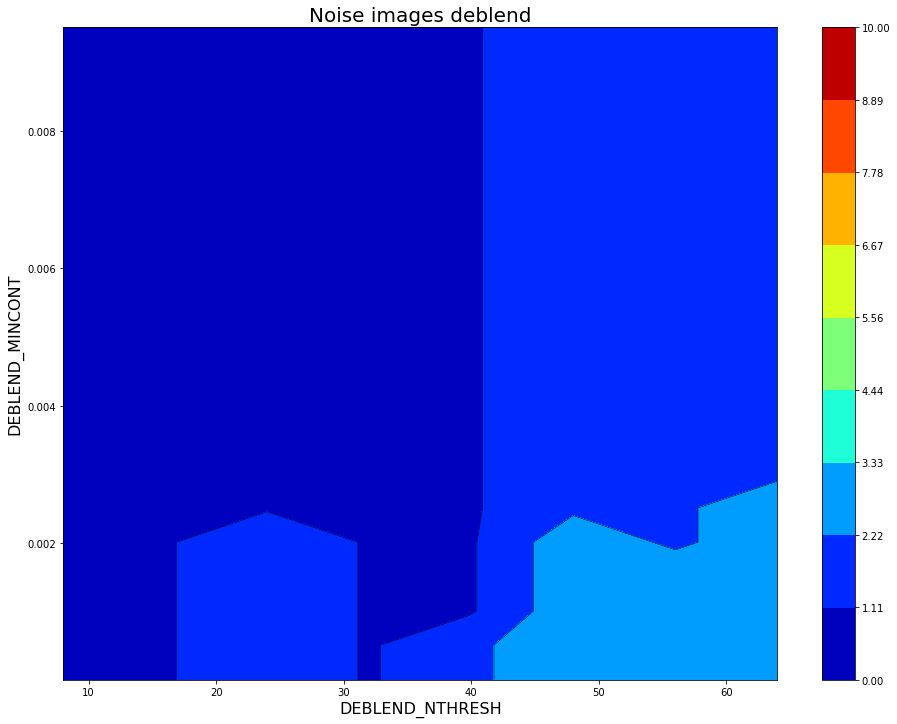

In [21]:
v = np.linspace(0., 10.0, 10, endpoint=True)
plt.figure(figsize = (16,12))
plt.contour(deb_nth, deb_min, N_2, v, linewidths=0.5, colors='k')
plt.contourf(deb_nth, deb_min, N_2, v, cmap=plt.cm.jet)

plt.xlabel('DEBLEND_NTHRESH',fontsize=16)
plt.ylabel("DEBLEND_MINCONT",fontsize=16)
plt.title("Noise images deblend",fontsize=20)
y = plt.colorbar(ticks=v)
print y
plt.show()




## Final comparison of three situations

In [22]:
flagtrue, flagsextractor, flagnetwork, flagofsex,oneblend0,oneblend2,onenoblend, twoobj,twoblend,twonoblend,twonoandblend,twoblendandno,more2_1,snr = sexparam(
                                        25,1.01, deblend_nth=64, deblend_min=0.00001, objs = blend_test,fitsname = 'objstest', catname = 'nonoiseobjs.cat')   

print oneblend0.shape[0],oneblend2.shape[0],onenoblend.shape[0],twoblend.shape[0],twonoblend.shape[0],twonoandblend.shape[0],more2_1.shape[0]




74 18 91 2 0 1 1


In [23]:
flagtrue, flagsextractor, flagnetwork, flagofsex,oneblend0,oneblend2,onenoblend, twoobj,twoblend,twonoblend,twonoandblend,twoblendandno,more2_1,snr = sexparam(
                                        35,1.01, deblend_nth=64, deblend_min=0.00001, objs = objs_test,fitsname = 'objstest', catname = 'nonoiseobjs.cat')   

print oneblend0.shape[0],oneblend2.shape[0],onenoblend.shape[0],twoblend.shape[0],twonoblend.shape[0],twonoandblend.shape[0],more2_1.shape[0]

149 59 59 1 144 16 0


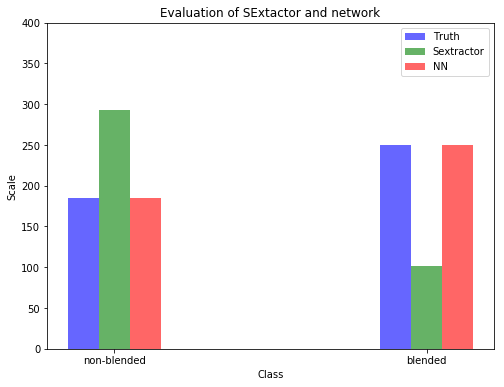

In [24]:

# Plot the evaluation
plt.figure(figsize=(8, 6))
index = np.arange(2)  
bar_width = 0.1 
opacity = 0.6

plt.bar(index, flagtrue, bar_width, alpha=opacity, color='b', label = 'Truth')  
plt.bar(index + bar_width, flagsextractor, bar_width, alpha=opacity, color='g', label ='Sextractor')  
plt.bar(index + 2*bar_width, flagnetwork, bar_width, alpha=opacity, color='r', label ='NN')  
plt.xlabel('Class')  
plt.ylabel('Scale')
plt.ylim(0,400)
plt.legend()
plt.title('Evaluation of SExtactor and network')  
plt.xticks(index + bar_width,('non-blended', 'blended'))  
plt.show()


In [25]:
print("SExtractor's blended proportion:", float(flagsextractor[1])/flagtrue[1])
print("Network's blended proportion:", float(flagnetwork[1])/flagtrue[1])

print("SExtractor's non-blended proportion:", float(flagsextractor[0])/flagtrue[0])
print("Network's non-blended proportion:", float(flagnetwork[0])/flagtrue[0])


("SExtractor's blended proportion:", 0.408)
("Network's blended proportion:", 1.0)
("SExtractor's non-blended proportion:", 1.5837837837837838)
("Network's non-blended proportion:", 1.0)


## Analyse the vignette

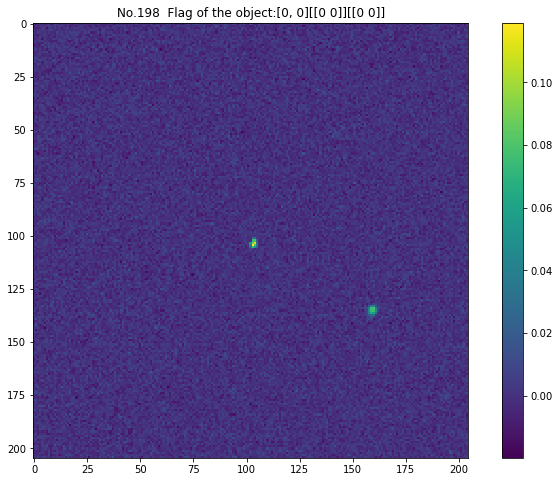

In [26]:
# for j in np.random.choice(range(center.shape[0]),2):#range(center.shape[0]): #
j = 198
plt.figure(figsize = (12, 8))
plt.imshow(objs_test[j], interpolation='Nearest', cmap='viridis')
plt.colorbar()
plt.title('No.'+str(j)+'  '+'Flag of the object:'+str(flagofsex[j])+str(flagnn[j])+str(flagtest[j]))#+str(flags[j]), fontsize=12)
plt.show()


In [28]:
command = 'sex ''files/'+'bletest200.fits -BACK_TYPE MANUAL -BACK_VALUE 0.0,0.0 -DETECT_MINAREA 15 -ANALYSIS_THRESH 0.002 -DETECT_THRESH 0.002 -DEBLEND_NTHRESH 64 -DEBLEND_MINCONT 0.00001 -CATALOG_NAME nonoiseobjs.cat'
output = sp.Popen([command] , stdout=sp.PIPE, stderr=sp.PIPE, shell=True).stderr.read()
print output

> 
----- SExtractor 2.19.5 started on 2017-12-06 at 19:30:54 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing check-image(s)
> Initializing catalog
> Looking for bletest200.fits
----- Measuring from: bletest200.fits
      "Unnamed" / no ext. header / 205x205 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 0          RMS: 0.00497501 / Threshold: 9.95002e-06 
> Scanning image
> Line:   25  Objects:       27 detected /        0 sextracted
> Line:   50  Objects:       49 detected /        0 sextracted
> Line:   75  Objects:       56 detected /        0 sextracted
> Line:  100  Objects:       95 detected /        0 sextracted
> Line:  125  Objects:      113 detected /        0 sextracted
> Line:  150  Objects:      141 detected /        0 sextracted
> Line:  175  Objects:      190 detected /        0 sextracted
> Li

In [30]:
# meansignal = []
# for i in np.arange(blend_test.shape[0]):

#     signal = fits.getdata('files/'+'bletest'+str(i)+'.fits')
#     sig = np.array(signal)
#     index = np.array(np.where(sig!=0))
#     a = sig[index[0,:],index[1,:]].mean()
#     meansignal.append(a)
# mean = np.array(meansignal).mean()
# print mean
# snr_im = 10*np.log(mean)
# print snr_im 